In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

from CustomCNN import CustomCNN

In [54]:
dataset_type = 'vary_disk'
data = torch.load(f'./data/classification_custom_dataset/{dataset_type}.pth')
images = data['images'].float() / 255
labels = data['labels']

In [55]:
# Create dataset
dataset = TensorDataset(images.unsqueeze(1), labels)  # Add channel dimension

# Split dataset: 70% for training and 20% for validation/testing
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
# Placeholders for metrics
train_losses = []
test_losses = []
test_accuracies = []

In [57]:
# Loss Function and Optimizer
model = CustomCNN(channels=32, kernel_size=3).cuda()  # .cuda() if using GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):

    model.train() 
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()  # .cuda() if using GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()


        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    
    # Calculate training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/25] Train Loss: 0.3901 Test Loss: 0.8235 Test Accuracy: 41.67%
Epoch [2/25] Train Loss: 0.1278 Test Loss: 1.3233 Test Accuracy: 41.67%
Epoch [3/25] Train Loss: 0.0955 Test Loss: 1.4875 Test Accuracy: 41.67%
Epoch [4/25] Train Loss: 0.0826 Test Loss: 1.4405 Test Accuracy: 41.67%
Epoch [5/25] Train Loss: 0.0833 Test Loss: 1.2371 Test Accuracy: 41.67%
Epoch [6/25] Train Loss: 0.0802 Test Loss: 0.8570 Test Accuracy: 41.67%
Epoch [7/25] Train Loss: 0.0816 Test Loss: 0.4047 Test Accuracy: 75.00%
Epoch [8/25] Train Loss: 0.0726 Test Loss: 0.1744 Test Accuracy: 96.67%
Epoch [9/25] Train Loss: 0.1009 Test Loss: 0.0908 Test Accuracy: 100.00%
Epoch [10/25] Train Loss: 0.0888 Test Loss: 0.0637 Test Accuracy: 100.00%
Epoch [11/25] Train Loss: 0.0877 Test Loss: 0.0540 Test Accuracy: 100.00%
Epoch [12/25] Train Loss: 0.0984 Test Loss: 0.0508 Test Accuracy: 100.00%
Epoch [13/25] Train Loss: 0.0778 Test Loss: 0.0505 Test Accuracy: 100.00%
Epoch [14/25] Train Loss: 0.0793 Test Loss: 0.0507 Test

In [58]:
# Saving model
torch.save(model.state_dict(), f'./Models/custom_cnn_classification_{dataset_type}.pth')

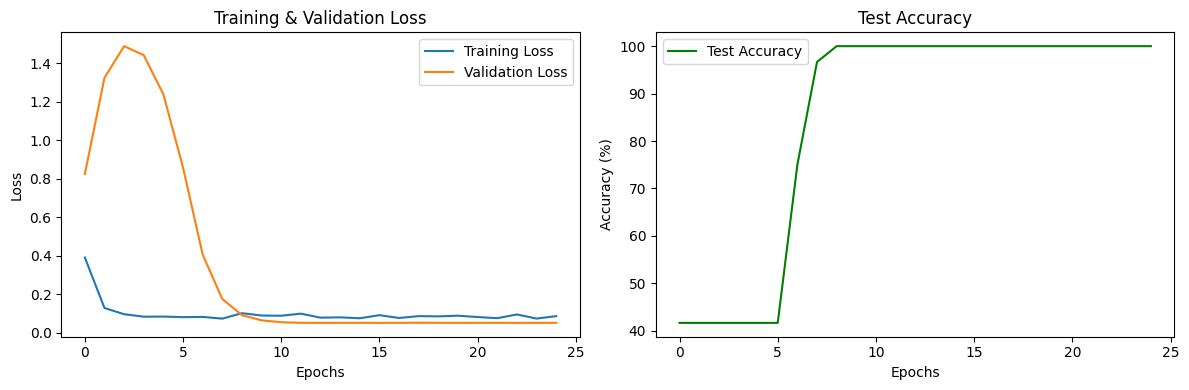

In [59]:
# 4. Plotting metrics
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
_ = plt.legend()

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
_ = plt.legend()

_ = plt.tight_layout()
_ = plt.show()

In [60]:
# Optional: Test the network on the test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()  # .cuda() if using GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 100 %


torch.Size([20, 1, 28, 28])


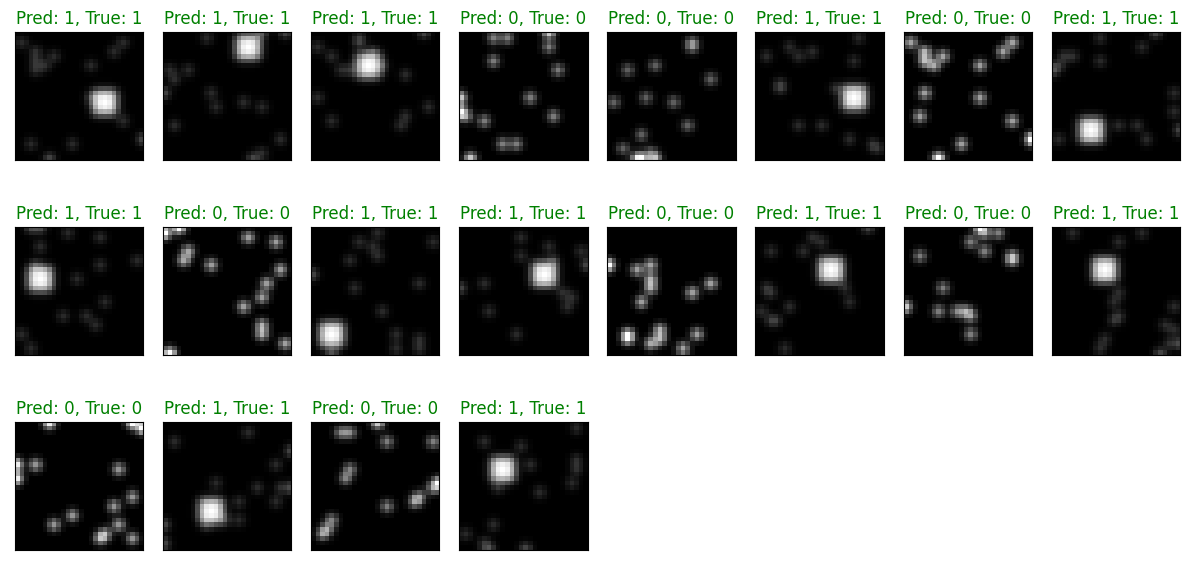

torch.Size([20, 1, 28, 28])


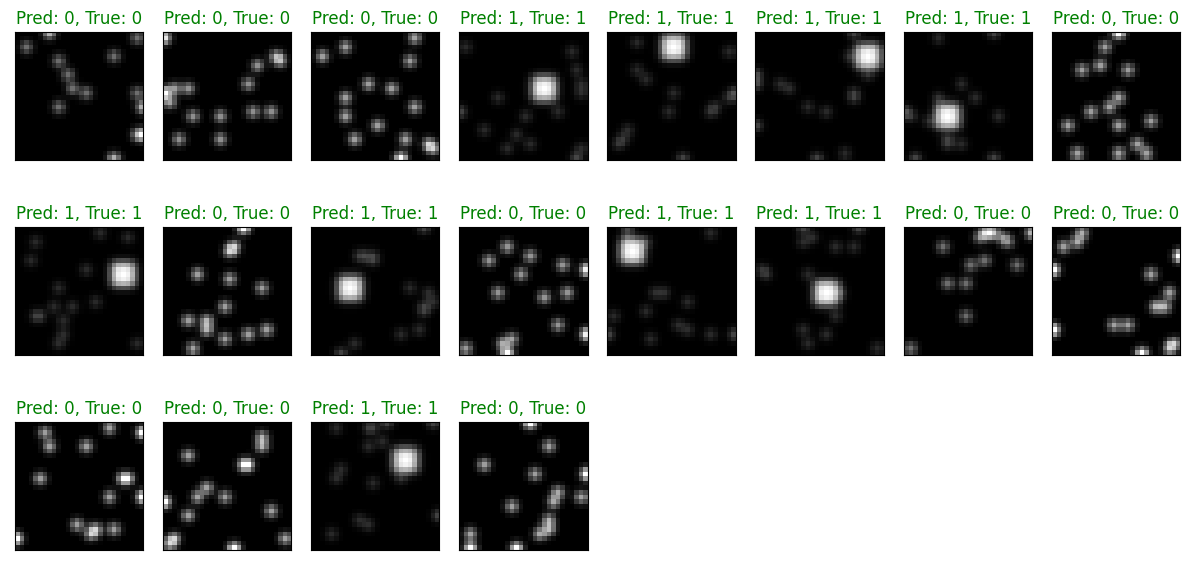

torch.Size([20, 1, 28, 28])


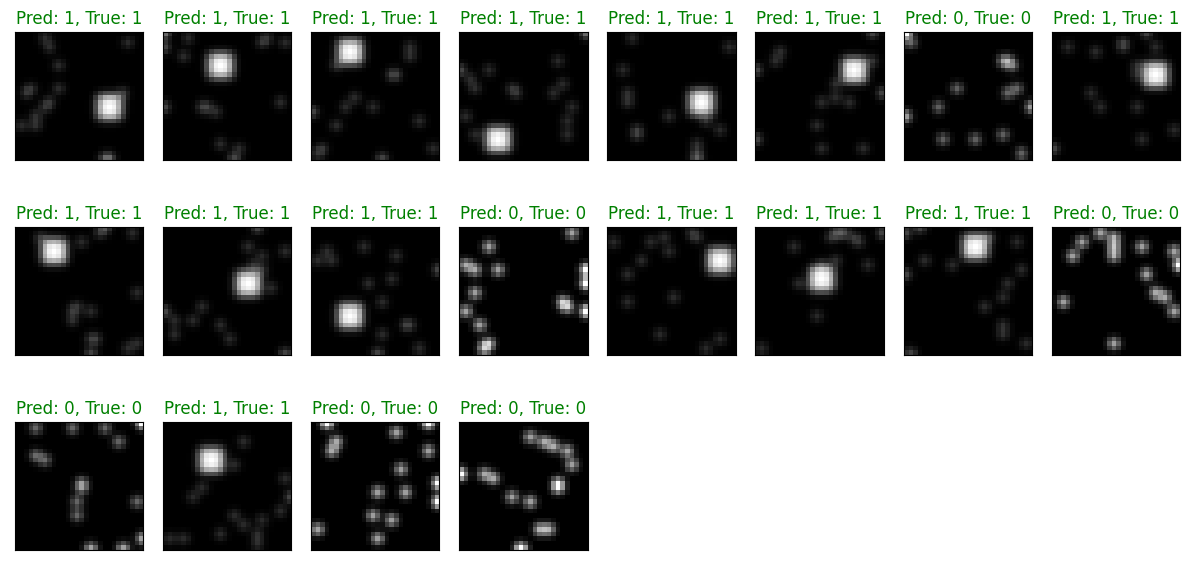

Accuracy of the network on the test images: 100 %


In [61]:
def imshow(img):
    # Convert from Tensor image
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img, cmap='gray')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        print(images.shape)
        images, labels = images.cuda(), labels.cuda()  # .cuda() if using GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Plotting
        fig = plt.figure(figsize=(12, 8))
        for index in range(len(images)):
            ax = fig.add_subplot(4, 8, index + 1, xticks=[], yticks=[])  # batch 32, 4 x 8
            imshow(images[index])
            ax.set_title(f"Pred: {predicted[index].item()}, True: {labels[index].item()}", 
                         color=("green" if predicted[index]==labels[index] else "red"))
        plt.tight_layout()  # Add padding between subplots
        plt.show()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))